In [ ]:
!pip install datasets >> log_datasets.txt
!pip install evaluate >> log_evaluate.txt
!pip install wandb >> log_wandb.txt


In [ ]:
# Upgrade datasets and fsspec to the latest versions
# This is necessary to ensure compatibility with the latest features and bug fixes.
!pip install --upgrade datasets fsspec >> log_update.txt

In [ ]:
import io
import numpy as np
import matplotlib.pyplot as plt
import evaluate
import accelerate
import itertools
from datasets import load_dataset, Image, ClassLabel
from PIL import Image as PILImage, ImageFile
import torch
from tqdm import tqdm
from transformers import ViTImageProcessor, ViTForImageClassification, pipeline, TrainingArguments, Trainer
from torchvision.transforms import (
    CenterCrop,  # Center crop an image
    Compose,  # Compose multiple image transformations
    Normalize,  # Normalize image pixel values
    RandomRotation,  # Apply random rotation to images
    RandomResizedCrop,  # Crop and resize images randomly
    RandomHorizontalFlip,  # Apply random horizontal flip
    RandomApply,
    RandomAdjustSharpness,  # Adjust sharpness randomly
    Resize,  # Resize images
    ToTensor  # Convert images to PyTorch tensors
)

import seaborn as sns
from sklearn.metrics import (  # Import various metrics from scikit-learn
    accuracy_score,  # For calculating accuracy
    roc_auc_score,  # For ROC AUC score
    confusion_matrix,  # For confusion matrix
    classification_report,  # For classification report
    f1_score  # For F1 score
)

ImageFile.LOAD_TRUNCATED_IMAGES = True

import wandb
wandb.login()
wandb.init(project="train_img_vit")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


eval/accuracy,▁▇█████
eval/loss,█▂▁▁▁▁▁
eval/model_preparation_time,▁▁▁▁▁▁▁
eval/runtime,█▂▁▁▁▁▂
eval/samples_per_second,▁▇████▇
eval/steps_per_second,▁▇████▇
train/epoch,▁▂▃▄▅▆▇█
train/global_step,▁▂▃▄▅▆▆▇█
train/grad_norm,▁█
train/learning_rate,█▁
train/loss,█▁


In [ ]:
raw_dataset = load_dataset("HazemAbdelkawy/emotions")       # dataset 1
raw_dataset_2 = load_dataset("oscarparro/emotion-images-affectnet")  # dataset 2

# Extraer los splits deseados (ej. 'train')
ds1 = raw_dataset["train"]
ds2 = raw_dataset_2["train"]

# Verifica que tengan las mismas columnas y tipos
print(ds1.column_names)
print(ds2.column_names)

['image', 'question', 'answer']
['image_path', 'label', 'image']


In [ ]:
ds1 = ds1.rename_column("answer", "label")
ds1 = ds1.remove_columns(["question"])
ds2 = ds2.remove_columns(["image_path"])

In [ ]:
id2label = {
    0: 'anger',
    1: 'disgust',
    2: 'fear',
    3: 'happy',
    4: 'neutral',
    5: 'sad',
    6: 'surprise'
}


In [ ]:
# Mapear valores de int → str
def decode_label(example):
    example["label"] = id2label[example["label"]]
    return example

ds2 = ds2.map(decode_label)

In [ ]:
from datasets import concatenate_datasets, load_dataset
dataset = concatenate_datasets([ds1, ds2])

# Aplicar el mapeo para cambiar "anger" a "angry"
def update_label(example):
    if example["label"].lower() == "anger":
        example["label"] = "angry"
    return example

dataset = dataset.map(update_label)
dataset = dataset.filter(lambda x: x["label"] != "content")

df = dataset.to_pandas()

In [ ]:
labels_list = ['sad' , 'disgust' , 'angry' , 'neutral' , 'fear' , 'surprise' , 'happy']

In [ ]:
label2id, id2label = dict(), dict()
for i, label in enumerate(labels_list):
    label2id[label] = (i)
    id2label[i] = label

print("Mapping of IDs to Labels:", id2label, '\n')
print("Mapping of Labels to IDs:", label2id)

Mapping of IDs to Labels: {0: 'sad', 1: 'disgust', 2: 'angry', 3: 'neutral', 4: 'fear', 5: 'surprise', 6: 'happy'} 

Mapping of Labels to IDs: {'sad': 0, 'disgust': 1, 'angry': 2, 'neutral': 3, 'fear': 4, 'surprise': 5, 'happy': 6}


In [ ]:
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)

def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

dataset = dataset.map(map_label2id, batched=True)

dataset = dataset.cast_column('label', ClassLabels)

dataset = dataset.train_test_split(test_size=0.2, shuffle=True, stratify_by_column="label", seed=33)

train_data = dataset['train']

test_data = dataset['test']

In [ ]:
model_str = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_str)
image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]
print("Tamaño de entrada del modelo:", size)

Tamaño de entrada del modelo: 224


In [ ]:
normalize = Normalize(mean=image_mean, std=image_std)

_train_transforms = Compose([
    Resize((size, size)),                         # Redimensiona las imágenes al tamaño requerido.
    RandomApply([RandomRotation(45)], p=0.8),       # Con un 80% de probabilidad, rota la imagen aleatoriamente hasta 45°.
    RandomApply([RandomAdjustSharpness(2)], p=0.3), # Con un 30% de probabilidad, ajusta la nitidez.
    RandomHorizontalFlip(0.5),                      # Aplica flip horizontal con 50% de probabilidad.
    ToTensor(),                                   # Convierte la imagen a tensor.
    normalize                                     # Normaliza la imagen.
])

_test_transforms = Compose([
    Resize((size, size)),  # Redimensiona las imágenes al tamaño requerido.
    ToTensor(),            # Convierte la imagen a tensor.
    normalize              # Normaliza las imágenes.
])

def train_transforms(examples):
    examples['pixel_values'] = [ _train_transforms(image.convert("RGB")) for image in examples['image'] ]
    return examples

def test_transforms(examples):
    examples['pixel_values'] = [ _test_transforms(image.convert("RGB")) for image in examples['image'] ]
    return examples


In [ ]:
train_data.set_transform(train_transforms)
test_data.set_transform(test_transforms)

In [ ]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example['label'] for example in examples])

    return {"pixel_values": pixel_values, "labels": labels}

In [ ]:
model = ViTForImageClassification.from_pretrained(model_str, num_labels=len(labels_list))

model.config.id2label = id2label
model.config.label2id = label2id

print(model.num_parameters(only_trainable=True) / 1e6)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


85.804039


In [ ]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions = eval_pred.predictions

    label_ids = eval_pred.label_ids

    predicted_labels = predictions.argmax(axis=1)
    acc_score = accuracy.compute(predictions=predicted_labels, references=label_ids)['accuracy']

    return {
        "accuracy": acc_score
    }

In [ ]:
metric_name = "accuracy"
model_name = "vit_affectnet"

num_train_epochs = 5

args = TrainingArguments(
    output_dir=model_name,
    logging_dir='./logs',
    eval_strategy="epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=32,
    num_train_epochs=num_train_epochs,
    weight_decay=0.02,
    warmup_steps=50,
    fp16=True,
    remove_unused_columns=False,
    save_strategy='epoch',
    load_best_model_at_end=True,
    save_total_limit=1,
    report_to="wandb",
)

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

<ipython-input-40-9c13e1b762e1>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.evaluate()

{'eval_loss': 1.9452327489852905,
 'eval_model_preparation_time': 0.0049,
 'eval_accuracy': 0.15521310565042343,
 'eval_runtime': 64.5886,
 'eval_samples_per_second': 111.521,
 'eval_steps_per_second': 3.499}

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy
1,No log,0.827681,0.004900,0.702207
2,No log,0.737720,0.004900,0.728308
3,0.930300,0.676174,0.004900,0.746633
4,0.930300,0.660688,0.004900,0.761349
5,0.561700,0.659255,0.004900,0.766347


TrainOutput(global_step=1130, training_loss=0.7133045669150564, metrics={'train_runtime': 2045.0267, 'train_samples_per_second': 70.434, 'train_steps_per_second': 0.553, 'total_flos': 1.116244638905131e+19, 'train_loss': 0.7133045669150564, 'epoch': 5.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.6592545509338379,
 'eval_model_preparation_time': 0.0049,
 'eval_accuracy': 0.7663473552686381,
 'eval_runtime': 39.7143,
 'eval_samples_per_second': 181.371,
 'eval_steps_per_second': 5.691,
 'epoch': 5.0}

In [ ]:
outputs = trainer.predict(test_data)

print(outputs.metrics)

{'test_loss': 0.6592545509338379, 'test_model_preparation_time': 0.0049, 'test_accuracy': 0.7663473552686381, 'test_runtime': 38.6655, 'test_samples_per_second': 186.29, 'test_steps_per_second': 5.845}


Accuracy: 0.7663
F1 Score: 0.7493


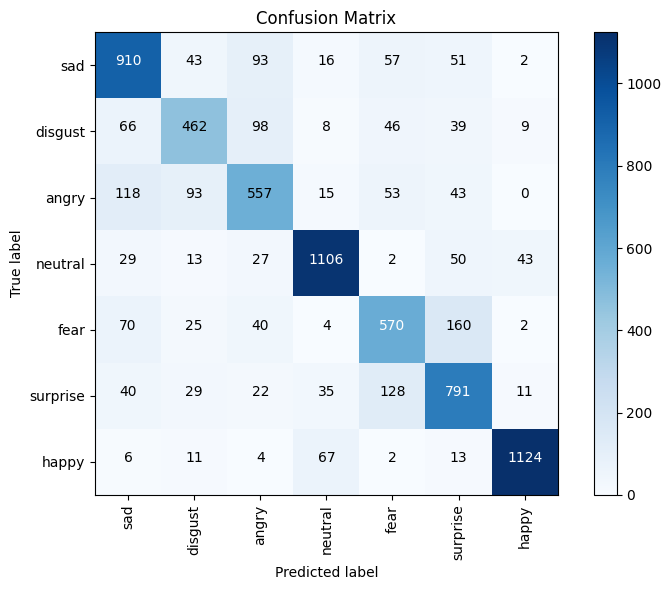


Classification report:

              precision    recall  f1-score   support

         sad     0.7345    0.7765    0.7549      1172
     disgust     0.6834    0.6346    0.6581       728
       angry     0.6623    0.6337    0.6477       879
     neutral     0.8841    0.8709    0.8774      1270
        fear     0.6643    0.6544    0.6593       871
    surprise     0.6896    0.7491    0.7181      1056
       happy     0.9437    0.9161    0.9297      1227

    accuracy                         0.7663      7203
   macro avg     0.7517    0.7479    0.7493      7203
weighted avg     0.7675    0.7663    0.7665      7203



In [ ]:
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8)):
    plt.figure(figsize=figsize)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.0f'
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.tight_layout()
    plt.show()

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

if len(labels_list) <= 150:
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, labels_list, figsize=(8, 6))

print()
print("Classification report:")
print()
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))

In [ ]:
trainer.save_model()

In [ ]:
# Import the necessary module to interact with the Hugging Face Hub.
from huggingface_hub import notebook_login

# Perform a login to the Hugging Face Hub.
notebook_login()

In [ ]:
# Import the HfApi class from the huggingface_hub library.
from huggingface_hub import HfApi

# Create an instance of the HfApi class.
api = HfApi()
model_name = "emotion_detection_vit"

# Define the repository ID by combining the username "dima806" with the model name.
repo_id = f"oscarparro/{model_name}"

try:
    # Attempt to create a new repository on the Hugging Face Model Hub using the specified repo_id.
    api.create_repo(repo_id)

    # If the repository creation is successful, print a message indicating that the repository was created.
    print(f"Repo {repo_id} created")
except:
    # If an exception is raised, print a message indicating that the repository already exists.
    print(f"Repo {repo_id} already exists")

Repo oscarparro/emotion_detection_vit already exists


In [ ]:
# Uploading a folder to the Hugging Face Model Hub
api.upload_folder(
    folder_path=model_name,  # The path to the folder to be uploaded
    path_in_repo=".",  # The path where the folder will be stored in the repository
    repo_id=repo_id,  # The ID of the repository where the folder will be uploaded
    repo_type="model",  # The type of the repository (in this case, a model repository)
    revision="main" # Revision name
)

optimizer.pt:   0%|          | 0.00/687M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

Upload 8 LFS files:   0%|          | 0/8 [00:00<?, ?it/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

scaler.pt:   0%|          | 0.00/988 [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/oscarparro/emotion_detection_vit/commit/d2bfc1591d374748026966b9c1a2e9e323d6bc1c', commit_message='Upload folder using huggingface_hub', commit_description='', oid='d2bfc1591d374748026966b9c1a2e9e323d6bc1c', pr_url=None, repo_url=RepoUrl('https://huggingface.co/oscarparro/emotion_detection_vit', endpoint='https://huggingface.co', repo_type='model', repo_id='oscarparro/emotion_detection_vit'), pr_revision=None, pr_num=None)